Edge Detector from Assigmnet 3 - Question 2.<br>
Shape Detector from Assigmnet 3 - Question 2.

In [19]:
# Imports
import cv2
import math
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import signal
import itertools

def zipAll(arr1, arr2):
    return list(itertools.product(arr1, arr2))

figsize = (15, 5)

# Print the full NumPy array
import sys
np.set_printoptions(threshold=sys.maxsize)

Text(0.5, 1.0, 'Original')

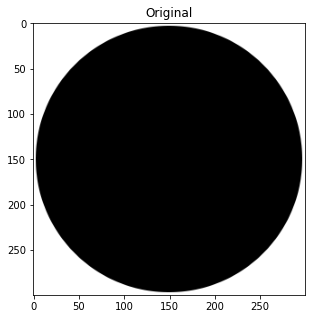

In [20]:
# Load the images in grayscale
path = "justCircleHuge.png"
#path = "justCircle.png" # 100r
#path = "justCircleSmaller.png" # 50r
#path = "justCircleSmallerSide.png" # 50r
#path = "justCircles.png"
#path = "justCircleInside.png" # 29r 61r
#path = "justCircleInsideCenter.png" # 29r 61r
#path = "justRad.png" # 61r
#path  = "justRectSmall.png"
#path = "Digital_all_labels.jpg"
#path = "Digital_all_labels_circle.jpg"
#path = "justRectangle.png"
#path = "rects_circles.png"
#path = "rects_circles_bigger.png" # unrunnable, takes more than 20min
#path = "rects_circles_medium.png"
#path = "why.png"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Resize img to smaller size (while keeping the same scale)
scale_img = False
max_img_size = 200

if scale_img:
    y_max, x_max = img.shape
    if y_max >= x_max:
        if y_max > max_img_size:
            scale = max_img_size / y_max
            width = int(x_max * scale)
            height = max_img_size # int(y_max * scale)
            dim = (width, height)
            img = cv2.resize(img, dim)
    else:
        if x_max > max_img_size:
            scale = max_img_size / x_max
            width = max_img_size # int(x_max * scale)
            height = int(y_max * scale)
            dim = (width, height)
            img = cv2.resize(img, dim)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(img, cmap='gray')
ax.set_title("Original")

In [21]:
# Blur the image
blur_image = False

if blur_image:
    blur = cv2.blur(img, (5,5))
    
    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(blur, cmap='gray')
    ax.set_title("Blur")
else:
    blur = np.copy(img)

In [22]:
# Sharpen the image
sharp_image = False

if sharp_image:
    sharp_kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1],
    ])
    sharp = cv2.filter2D(blur, ddepth=cv2.CV_64F, kernel=sharp_kernel).astype(np.float)

    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(sharp, cmap='gray')
    ax.set_title("Sharp")
else:
    sharp = np.copy(blur)

Text(0.5, 1.0, 'Edge Detector')

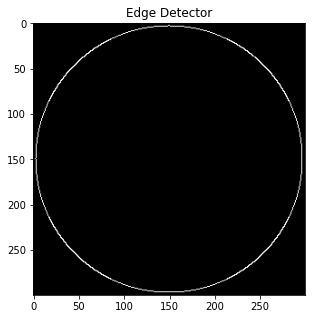

In [23]:
# Edge Detector
t1 = 20
t2 = t1 * 3
edges = cv2.Canny(sharp, t1, t2)
# convert edges from image of (0s and 255s) to (0s and 1s).
normalizer = lambda x: (x / 255)
edges = np.array([ [normalizer(rowCol) for rowCol in row] for row in edges])

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Edge Detector")

In [24]:
# Shape Detector
detect_shapes = True
detect_circles = True
detect_rectangles = False

threshold = 0.10 # a number between 0 and 1 (include edges)
significant_digits = 2
scale_interval = 0.01
interval_digits = 2

def getImgIndex(kernel_max_size):
    if kernel_max_size%2 == 0:
        return int((kernel_max_size/2)-1)
    else:
        return int((kernel_max_size-1)/2)

def overlapping_circles(center1, radius1, center2, radius2):
    y1, x1 = center1
    y2, x2 = center2
    return radius1 + radius2 > norm([y1-y2, x1-x2])

def overlapping_rectangles(center1, width1, height1, center2, width2, height2):
    y1, x1 = center1
    y2, x2 = center2
    # More understandable equation: (height1/2) + (height2/2) > abs(y1 - y2) and (...)
    return (height1 + height2 > 2 * abs(y1 - y2)) and (width1 + width2 > 2 * abs(x1 - x2))

def overlapping_rectangle_circle(center1, width1, height1, center2, radius2):
    y1, x1 = center1
    y2, x2 = center2
    
    distance_x_axis = abs(x1 - x2)
    distance_y_axis = abs(y1 - y2)
    half_width1 = width1/2
    half_height1 = height1/2

    if distance_x_axis > half_width1 + radius2:
        return False
    elif distance_y_axis > half_height1 + radius2:
        return False
    elif distance_x_axis <= half_width1:
        return True
    elif distance_y_axis <= half_height1:
        return True
    else:
        distance_corner = pow(distance_x_axis - half_width1, 2) + pow(distance_y_axis - half_height1, 2)
        return distance_corner <= pow(radius2, 2)

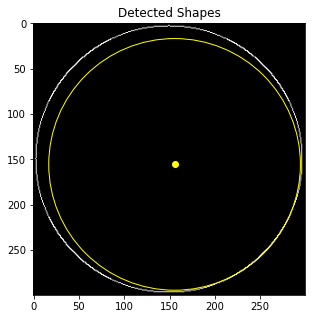

In [25]:
# Initializing result arrays for circles
circles_center = []
circles_radius = []
circles_cover  = [] # Only used to compare between choosen shapes
circles_scale  = [] # For debugging only.

# Initializing result arrays for rectangles
rectangles_center = []
rectangles_width  = []
rectangles_height = []
rectangles_cover  = [] # Only used to compare between choosen shapes
rectangles_scale  = [] # For debugging only.

# Note about comparing overlapping shapes: we prefer the bigger (area) shape.

def insert_circle(scale, center, radius, cover):
    to_be_remove = []
    
    for index in range(len(circles_center)):
        if overlapping_circles(center, radius, circles_center[index], circles_radius[index]):
            if round(cover, significant_digits) >= round(circles_cover[index], significant_digits):
                # We found a circle that is worst than the current one
                # Note: we also include equal here, we chose to remove because
                # we iterate from smallest radius to biggest, and the current one
                # will also be bigger or equal than those in circles_radius,
                # so we prefer the bigger radius if possible.
                to_be_remove.append(index)
            else:
                # We found a circle better than the current one,
                # no need to remove to_be_remove and no need to add current.
                return
    
    for index in reversed(to_be_remove):
        del circles_center[index]
        del circles_radius[index]
        del circles_cover [index]
        del circles_scale [index]
    
    circles_center.append(center)
    circles_radius.append(radius)
    circles_cover.append(cover)
    circles_scale.append(scale)

if detect_shapes:
    y_max, x_max = edges.shape

    # Detecting Circles
    radius = 25 # Minimum radius that will be checked
    # TODO: choose a dynamic min_radius according to the original image size

    # Creating the circle's kernel
    kernel_size = (2 * radius) + 1
    kernel_center = int(kernel_size/2)
    kernel = cv2.circle(
                np.zeros((kernel_size, kernel_size)),
                (kernel_center, kernel_center),
                radius,
                color=1,
                thickness=1)
    y_max_ker, x_max_ker = kernel.shape
    
    # Calculating the circumferences of each circle
    unique, counts = np.unique(kernel, return_counts=True)
    zero_one_dict = dict(zip(unique, counts))
    circumference = zero_one_dict[1]
    # Note: this isn't equal to 2*math.pi*radius

    # Max radius that can be found in the image: round(min(y_max,x_max) / 2)
    # So we need to scale kernel by: round(min(y_max,x_max) / 2) / radius
    # So we need to scale the img by: 1 / (round(min(y_max,x_max) / 2) / radius)
    max_scale = radius / round(min(y_max, x_max) / 2)
    # Rounding up
    temp = pow(10, interval_digits)
    max_scale = (int(max_scale * temp) + 1) / temp

    # Iterating each scale, from biggest to smallest.
    for scale in np.linspace(1, 0, int(1/scale_interval) + 1):
        if scale < max_scale:
            break
        scale = round(scale, interval_digits) # removing round errors

        # Scaling the image
        x_max_scale = int(x_max * scale)
        y_max_scale = int(y_max * scale)
        dim = (x_max_scale, y_max_scale)
        edges_scale = cv2.resize(edges, dim, interpolation=cv2.INTER_AREA)
        ceiler = lambda x: float(math.ceil(x))
        edges_scale = np.array([ [ceiler(rowCol) for rowCol in row] for row in edges_scale])

        if y_max_scale < y_max_ker or x_max_scale < x_max_ker:
            break

        # Compute the accumulator for each possible radius
        hough = signal.convolve2d(edges_scale, kernel, mode='valid')

        # Seaching for circles in current hough
        reverse_scale = 1 / scale
        y_dim,     x_dim     = hough.shape # getting smaller and smaller with each iteration
        y_move = getImgIndex(y_max_ker)
        x_move = getImgIndex(x_max_ker)
        for y in range(y_dim):
            for x in range(x_dim):
                cover = hough[y][x] / circumference
                if cover > threshold:
                    insert_circle(scale, ((y_move+y) * reverse_scale, (x_move+x) * reverse_scale), radius * reverse_scale, cover)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Detected Shapes")

if detect_shapes:
    # mark the center of the circles by a yellow point
    ax.plot([tpl[1] for tpl in circles_center], [tpl[0] for tpl in circles_center], 'o', color='yellow')
    # draw the circumference of the circles in blue
    for (y, x), radius in zip(circles_center, circles_radius):
        circ = plt.Circle((x, y), radius, color='yellow', fill=False)
        ax.add_artist(circ)

In [26]:
print("============================================================================== Circles ==============================================================================")
for (y, x), radius, cover, scale in zip(circles_center, circles_radius, circles_cover, circles_scale):
    print("Scale: %.2f\tCoordinate: (%19.15f,%19.15f)\tRadius: %19.15f\tCover: %.52f" % (scale, y, x, radius, cover))

print("============================================================================ Rectangles =============================================================================")
for (y, x), width, height, cover, scale in zip(rectangles_center, rectangles_width, rectangles_height, rectangles_cover, rectangles_scale):
    print("Scale: %.2f\tCoordinate: (%19.15f,%19.15f)\tWidth: %19.15f\tHeight: %19.15f\tCover: %.52f" % (scale, y, x, width, height, cover))

============================================================================== Circles ==============================================================================
Scale: 0.18	Coordinate: (155.555555555555543,155.555555555555543)	Radius: 138.888888888888886	Cover: 0.2571428571428571174806165799964219331741333007812500
============================================================================ Rectangles =============================================================================


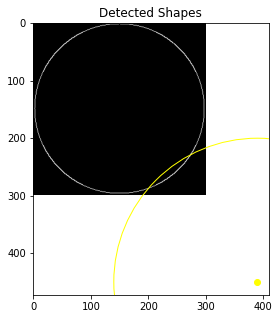

In [27]:

# Initializing result arrays for circles
circles_center = []
circles_radius = []
circles_cover  = [] # Only used to compare between choosen shapes
circles_scale  = [] # For debugging only.

# Initializing result arrays for rectangles
rectangles_center = []
rectangles_width  = []
rectangles_height = []
rectangles_cover  = [] # Only used to compare between choosen shapes
rectangles_scale  = [] # For debugging only.

# Note about comparing overlapping shapes: we prefer the bigger (area) shape.

def insert_circle(scale, center, radius, cover):
    to_be_remove = []
    
    for index in range(len(circles_center)):
        if overlapping_circles(center, radius, circles_center[index], circles_radius[index]):
            if round(cover, significant_digits) >= round(circles_cover[index], significant_digits):
                # We found a circle that is worst than the current one
                # Note: we also include equal here, we chose to remove because
                # we iterate from smallest radius to biggest, and the current one
                # will also be bigger or equal than those in circles_radius,
                # so we prefer the bigger radius if possible.
                to_be_remove.append(index)
            else:
                # We found a circle better than the current one,
                # no need to remove to_be_remove and no need to add current.
                return
    
    for index in reversed(to_be_remove):
        del circles_center[index]
        del circles_radius[index]
        del circles_cover [index]
        del circles_scale [index]
    
    circles_center.append(center)
    circles_radius.append(radius)
    circles_cover.append(cover)
    circles_scale.append(scale)


y_max, x_max = edges.shape

# Detecting Circles
radius = 25 # Minimum radius that will be checked
# TODO: choose a dynamic min_radius according to the original image size

# Creating the circle's kernel
kernel_size = (2 * radius) + 1
kernel_center = int(kernel_size/2)
kernel = cv2.circle(
            np.zeros((kernel_size, kernel_size)),
            (kernel_center, kernel_center),
            radius,
            color=1,
            thickness=1)
y_max_ker, x_max_ker = kernel.shape

# Calculating the circumferences of each circle
unique, counts = np.unique(kernel, return_counts=True)
zero_one_dict = dict(zip(unique, counts))
circumference = zero_one_dict[1]
# Note: this isn't equal to 2*math.pi*radius

# Max radius that can be found in the image: round(min(y_max,x_max) / 2)
# So we need to scale kernel by: round(min(y_max,x_max) / 2) / radius
# So we need to scale the img by: 1 / (round(min(y_max,x_max) / 2) / radius)
max_scale = radius / round(min(y_max, x_max) / 2)
# Rounding up
temp = pow(10, interval_digits)
max_scale = (int(max_scale * temp) + 1) / temp

# Iterating each scale, from biggest to smallest.
scale = 0.10
    

# Scaling the image
x_max_scale = int(x_max * scale)
y_max_scale = int(y_max * scale)
dim = (x_max_scale, y_max_scale)
edges_scale = cv2.resize(edges, dim, interpolation=cv2.INTER_AREA)
ceiler = lambda x: float(math.ceil(x))
edges_scale = np.array([ [ceiler(rowCol) for rowCol in row] for row in edges_scale])

# Compute the accumulator for each possible radius
hough = signal.convolve2d(edges_scale, kernel, mode='valid')

circumference_scale = circumference * scale

# Seaching for circles in current hough
reverse_scale = 1 / scale
y_dim,     x_dim     = hough.shape # getting smaller and smaller with each iteration
y_move = getImgIndex(y_max_ker)
x_move = getImgIndex(x_max_ker)
for y in range(y_dim):
    for x in range(x_dim):
        cover = hough[y][x] / circumference
        if cover > threshold:
                if ((y_move+y) * reverse_scale, (x_move+x) * reverse_scale) == ( 36.363636363636360, 36.363636363636360):
                    print(y,x, (y_move+y), (x_move+x))
                insert_circle(scale, ((y_move+y) * reverse_scale, (x_move+x) * reverse_scale), radius * reverse_scale, cover)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Detected Shapes")

if detect_shapes:
    # mark the center of the circles by a yellow point
    ax.plot([tpl[1] for tpl in circles_center], [tpl[0] for tpl in circles_center], 'o', color='yellow')
    # draw the circumference of the circles in blue
    for (y, x), radius in zip(circles_center, circles_radius):
        circ = plt.Circle((x, y), radius, color='yellow', fill=False)
        ax.add_artist(circ)

In [28]:
print("============================================================================== Circles ==============================================================================")
for (y, x), radius, cover, scale in zip(circles_center, circles_radius, circles_cover, circles_scale):
    print("Scale: %.2f\tCoordinate: (%19.15f,%19.15f)\tRadius: %19.15f\tCover: %.52f" % (scale, y, x, radius, cover))

print("============================================================================ Rectangles =============================================================================")
for (y, x), width, height, cover, scale in zip(rectangles_center, rectangles_width, rectangles_height, rectangles_cover, rectangles_scale):
    print("Scale: %.2f\tCoordinate: (%19.15f,%19.15f)\tWidth: %19.15f\tHeight: %19.15f\tCover: %.52f" % (scale, y, x, width, height, cover))

============================================================================== Circles ==============================================================================
Scale: 0.10	Coordinate: (450.000000000000000,390.000000000000000)	Radius: 250.000000000000000	Cover: 0.1071428571428571369095195109366613905876874923706055
============================================================================ Rectangles =============================================================================


In [43]:
scale = 0.10
radius = 25
reverse_scale = 1 / scale
print(radius, reverse_scale, radius * reverse_scale)

25 10.0 250.0


In [44]:
x_max_scale = int(x_max * scale)
y_max_scale = int(y_max * scale)
dim = (x_max_scale, y_max_scale)
edges_scale = cv2.resize(edges, dim, interpolation=cv2.INTER_AREA)
ceiler = lambda x: float(math.ceil(x))
edges_scale = np.array([ [ceiler(rowCol) for rowCol in row] for row in edges_scale])

Text(0.5, 1.0, 'Detected Shapes')

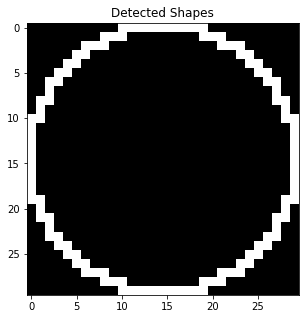

In [45]:
# print(edges_scale)
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges_scale, cmap='gray')
ax.set_title("Detected Shapes")

In [ ]:
print(hough, circumference, circumference_scale)

In [ ]:
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(hough, cmap='gray')
ax.set_title("Detected Shapes")